In [3]:
# !usr/bin/python
# -*- encoding: utf-8 -*-
# Project: Multi-Head Attention
# Author: Tracy Tao
# Date: 2022/04/19
import torch
import math
from torch import nn
from d2l import torch as d2l

- 多头注意力机制组合使用QKV
    - 独立学习h组线性投影变换QKV，并行送到注意力汇聚成一个head
    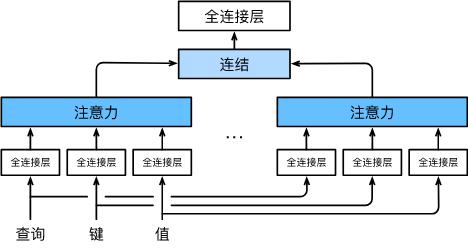

In [7]:
class MultiHeadAttention(nn.Module):
    ''' 缩放点积注意力 '''
    def __init__(self, key_size, query_size, value_size, 
                 num_hiddens, num_heads, dropout, bias = False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        #### 全连接 ####
        self.W_q = nn.Linear(query_size, num_hiddens, bias = bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias = bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
    
    def forward(self, queries, keys, values, valid_lens):
        '''
        QKV + d
        Q: (batch_size, q_size, num_hiddens)
        K: (batch_size, k_size, num_hiddens)
        V: (batch_size, v_size, num_hiddens)
        valid_lens: (batch_size，)/(batch_size，q_size)
        -> (batch_size * num_heads, size, num_hiddens / num_heads)
        '''
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(valid_lens, repeats = self.num_heads, dim = 0)
        
        output = self.attention(queries, keys, values, valid_lens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)
        
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    X = X.permute(0, 2, 1, 3)
    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])   

def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

**多头注意力输出的形状是（batch_size，num_queries，num_hiddens）**

In [8]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)